# Analysis of snRNA-seq2 data from young healthy mice

## Library and data import

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from gprofiler import gprofiler
import os
import sys
sys.path.append('/Users/carmenrobinson/Documents/GitHub/snRNA-seq2_young/initial_submission/')
from scipy import stats
from venn import venn
import custom_functions as cf
path="/Users/carmenrobinson/Documents/GitHub/snRNA-seq2_young/"

#### Figure parameters

In [2]:
sc.settings.set_figure_params(dpi=80)

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=500,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

#### Load raw count matrix

In [3]:
adata1=ad.read('adata_rRNA.h5ad')

In [5]:
adata1.obs_names.rename[""]

Index(['do20279', 'do20280', 'do20281', 'do20282', 'do20283', 'do20284',
       'do20285', 'do20286', 'do20287', 'do20288',
       ...
       'ID-SNI-626-9-G', 'ID-SNI-626-9-H', 'ID-SNI-626-9-I', 'ID-SNI-626-9-J',
       'ID-SNI-626-9-K', 'ID-SNI-626-9-L', 'ID-SNI-626-9-M', 'ID-SNI-626-9-N',
       'ID-SNI-626-9-O', 'ID-SNI-626-9-P'],
      dtype='object', length=4224)

In [5]:
adata2=ad.read("/Users/carmenrobinson/Documents/GitHub/snRNA-seq2_young/initial_submission/snRNAseq_mouse_hepatocytes_young_apr21_raw_with_metadata.h5ad")

In [6]:
adata2.obs_he

,Sample,Mapped,ERCC,Endogenous,exp.,Experiment,Genome,Strain,ID.Individual,Tissue,...,ERCC.dilution,Sequencer,column,row,percentERCC\n,exon_counts,intron_counts,rrna,inferred_cell_label,passing_QC
do20279,do20279,121204,93031,56346,SNI-193,CM-SNI-193-1-A,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1 in 100.000,HiSeq4000,1,A,0.767557176330814\n,2380.0,9842.0,55.0,B-cells,pass
do20280,do20280,297307,284041,26532,SNI-193,CM-SNI-193-1-B,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1 in 100.000,HiSeq4000,1,B,0.955379456252291\n,2577.0,5336.0,74.0,NA,fail
do20281,do20281,541845,526222,31246,SNI-193,CM-SNI-193-1-C,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1 in 100.000,HiSeq4000,1,C,0.971167031162048\n,1804.0,4240.0,251.0,NA,fail
do20282,do20282,339913,299674,80478,SNI-193,CM-SNI-193-1-D,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1 in 100.000,HiSeq4000,1,D,0.881619708572488\n,4037.0,15315.0,18.0,Stellate cells,pass
do20283,do20283,408637,283364,250546,SNI-193,CM-SNI-193-1-E,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1 in 100.000,HiSeq4000,1,E,0.693436962389603\n,23773.0,49474.0,297.0,Hepatocytes,pass


In [7]:
adata=adata2

adata = ad.read("/home/maria/projects/mouse/polyploidy_healthy_young/data/matrices/snRNAseq_mouse_hepatocytes_young_jan21_raw_with_metadata.h5ad")

In [8]:
# remove the "\n" in the last column of the sample annotation and make the column numeric
annot = []
for elem in adata.obs["percentERCC\n"]:
    annot.append(elem[:-1])
adata.obs["percentERCC"] = annot
del adata.obs["percentERCC\n"]
del annot
adata.obs["percentERCC"] = pd.to_numeric(adata.obs["percentERCC"]) 

In [9]:
# remove the additional output from htseq-count from the matrix
amb = []
for i in adata.var_names:
    if i[0:2] != "__":
        amb.append(i)
        
adata = adata[:,amb].copy()

In [10]:
# split ERCC counts into a different object
ERCC = []
for i in adata.var_names:
    if i[0:3] != "ENS" and i[0:2] != "__":
        ERCC.append(i)
        
adataERCC = adata[:,ERCC].copy()

In [11]:
# split endogenous transcript counts into a different object
transc = []
for i in adata.var_names:
    if i[0:3] == "ENS":
        transc.append(i)

adataT = adata[:,transc].copy()

In [12]:
adata.obs['n_counts_raw'] = adata.X.sum(axis=1) # endogeneous transcripts + ERCCs
adata.obs["n_counts_transcripts"] = np.sum(adataT.X, axis=1) # endogenous transcripts only
adata.obs["n_counts_ERCC"] = np.sum(adataERCC.X, axis=1) # ERCCs only

#### Create Figure 1B: mean number of features (transcripts, introns, exons, rRNA) as bar plot

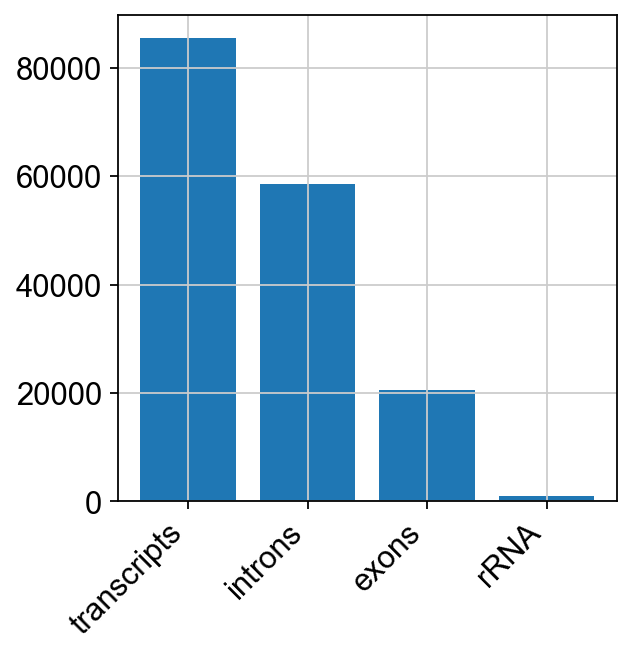

In [13]:
t = np.mean(adata.obs["n_counts_transcripts"])
i = np.mean(adata.obs["intron_counts"])
e = np.mean(adata.obs["exon_counts"])
r = np.mean(adata.obs["rrna"])

x = np.arange(4)
variable = [t, i , e, r]

fig, ax = plt.subplots()
plt.bar(x, variable)
plt.xticks(x, ('transcripts', 'introns', 'exons', 'rRNA'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### Save number of genes per nucleus and number of detected protein coding genes as .csv for comparison to other methods

In [14]:
# remove cells that have no genes expressed in order to better visualize the cutoffs
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_cells(adata, min_counts=1)

In [15]:
# number of genes per cell for comarison to other methods
df = pd.DataFrame()
df["n_genes"] = adata.obs["n_genes"]
df["dataset"] = "snRNAseq2"
df.to_csv("comparing_datasets/snRNAseq2.csv")

In [16]:
# load all the csvs and concatenate for violin plot
dire = path
bahar2017 = pd.read_csv(dire+"comparing_datasets/bahar_2017_MARSseq.csv")
tm2018_10x = pd.read_csv(dire+"comparing_datasets/tabula_muris_2018_10X.csv")
tm2018_ss2 = pd.read_csv(dire+"comparing_datasets/tabula_muris_2018_smartseq.csv")
aizarani2019 = pd.read_csv(dire+"comparing_datasets/aizarani_human_liver_2019_CELLseq.csv")
nault2020 = pd.read_csv(dire+"comparing_datasets/nault_2020_10X.csv")
snRNAseq2 = pd.read_csv(dire+"comparing_datasets/snRNAseq2.csv")
own10X = pd.read_csv(dire+"comparing_datasets/own_data_10X_cruk.csv")
own10X_LB2 = pd.read_csv(dire+"comparing_datasets/own_data_10X_cruk_LB2.csv")
snRNAseq = pd.read_csv(dire+"comparing_datasets/own_data_no_LB2.csv")

In [17]:
x = pd.concat([snRNAseq2, bahar2017], ignore_index=True)
y = pd.concat([x,tm2018_10x], ignore_index=True)
z = pd.concat([y,tm2018_ss2], ignore_index=True)
u = pd.concat([z,aizarani2019], ignore_index=True)
t = pd.concat([u,nault2020], ignore_index=True)

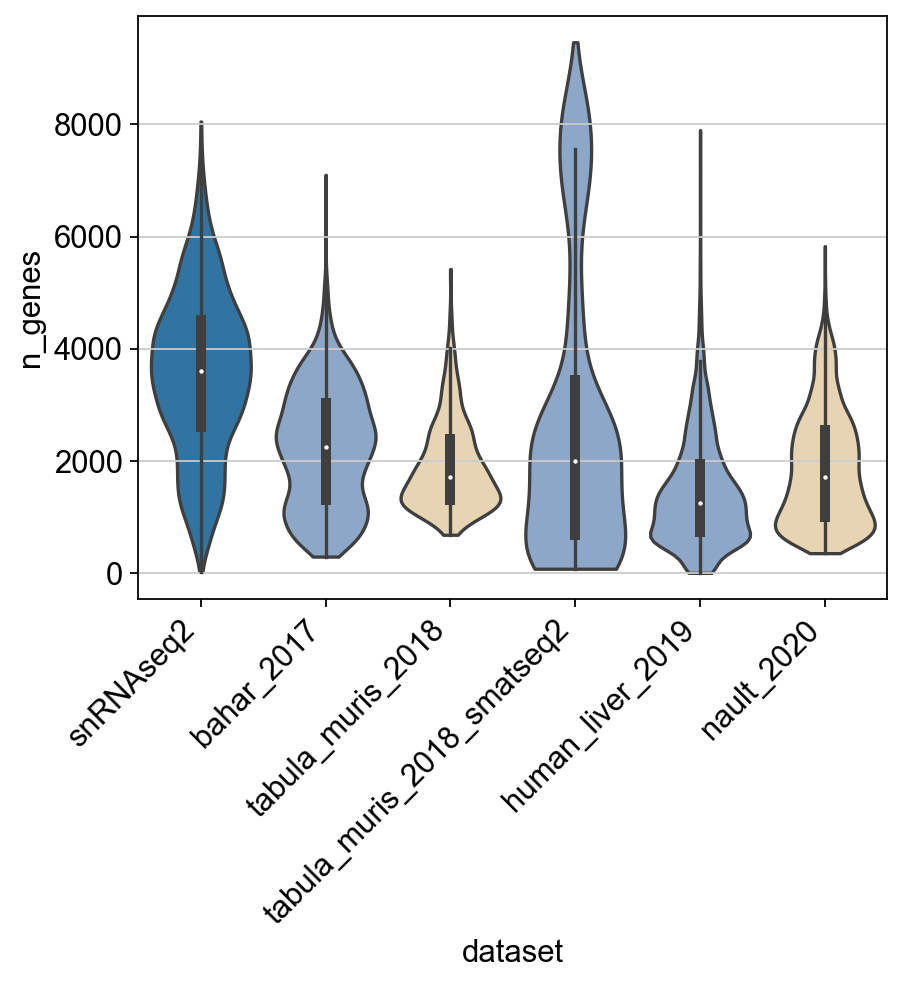

In [18]:
cols = {"snRNAseq2":"#1f77b4", "bahar_2017":"#82a6d1", "tabula_muris_2018":"#efd7a9",
        "tabula_muris_2018_smatseq2":"#82a6d1", "human_liver_2019":"#82a6d1",
        "nault_2020":"#efd7a9"}

ax = sns.violinplot(x="dataset", y="n_genes", data=t, palette=cols, scale="width", cut=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.5, box.height * 1.2])

In [19]:
adata2 = adata[:,adata.var["biotype"] == "protein_coding"]

In [20]:
df = pd.DataFrame()
df["gene_name"] = adata2.var["gene_name"].tolist()
df["gene_id"] = adata2.var_names.tolist()
df["dataset"] = "snRNAseq2"
df.to_csv("comparing_datasets/snRNAseq2_protein_coding_genes.csv")

In [21]:
snRNAseq2 = pd.read_csv("comparing_datasets/snRNAseq2_protein_coding_genes.csv")
snRNAseq = pd.read_csv("comparing_datasets/own_data_no_LB2_protein_coding_genes.csv")
own10X = pd.read_csv("comparing_datasets/own_data_10X_cruk_genes.csv")
own10X_LB2 = pd.read_csv("comparing_datasets/own_data_10X_cruk_LB2_genes.csv")

In [22]:
genes = {snRNAseq2["dataset"][0]:set(snRNAseq2["gene_name"]),
         snRNAseq["dataset"][0]:set(snRNAseq["gene_name"]),
         own10X["dataset"][0]:set(own10X["gene_name"]),
         own10X_LB2["dataset"][0]:set(own10X_LB2["gene_name"])}

<Axes: >

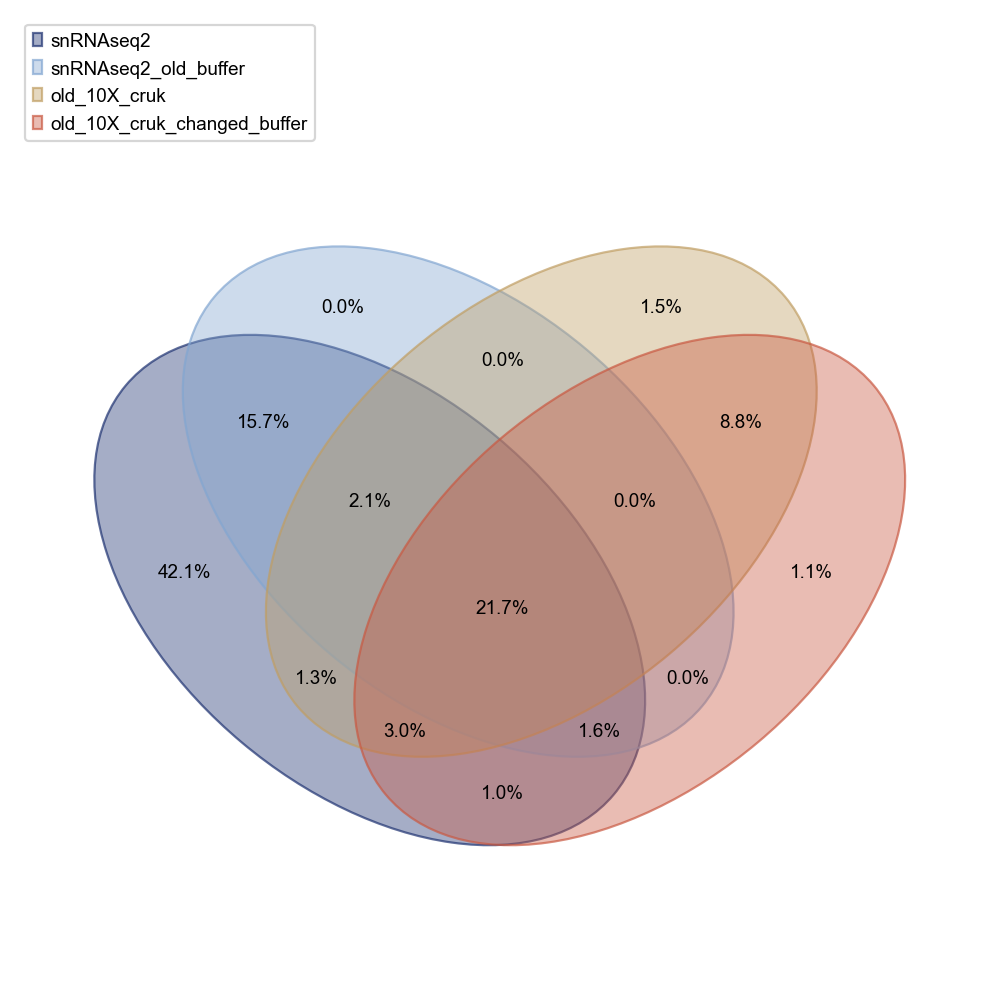

In [23]:
venn(genes, legend_loc="upper left", fmt="{percentage:.1f}%", fontsize=8.5, 
     cmap=["#1e3271","#82a6d1","#c09e63","#c95942"])

## Filtering

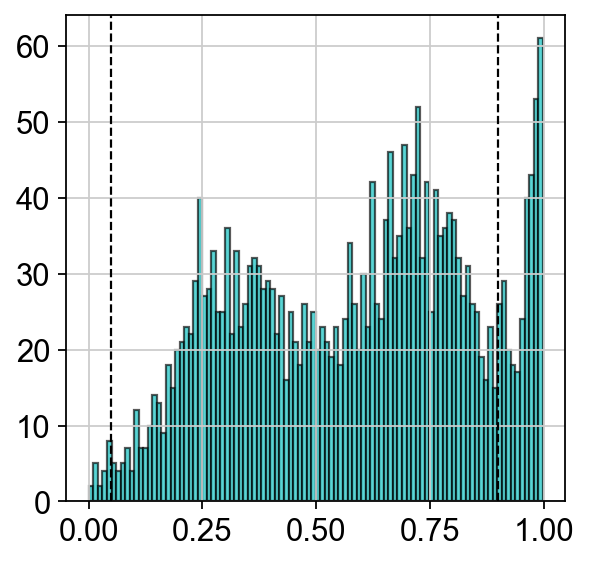

In [24]:
# visualize cutoffs for filtering cells based on their percentage of ERCC reads
p = plt.hist(adata.obs["percentERCC"], bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(0.9, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.05, color='k', linestyle='dashed', linewidth=1)

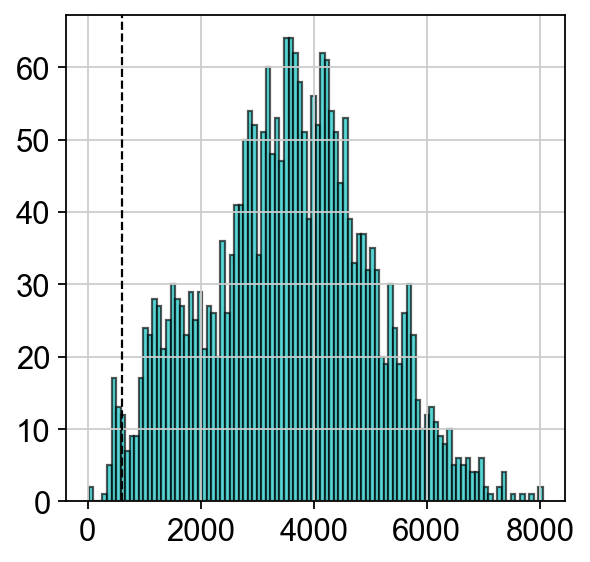

In [27]:
# visualize lower cutoff for filtering cells based on the number of genes
p = plt.hist(adata.obs["n_genes"], bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(600, color='k', linestyle='dashed', linewidth=1)

In [50]:
#adata_new = adata[adata.obs["percentERCC"] <= 0.9,:].copy()
adata_new = adata_new[adata_new.obs["percentERCC"] > 0.05,:].copy()

sc.pp.filter_cells(adata_new, min_genes=1000)
#sc.pp.filter_cells(adata_new, max_genes=7000)


#sc.pp.filter_genes(adata_new, min_cells=25) # roughly 1% of the population
#sc.pp.filter_genes(adata_new, min_counts=250)

In [51]:
## further filtering: 
adata2 = adata_new.copy()

# remove cells with 2x2n and - ploidy (doublets and empty wells from FACS failure)
adata2 = adata2[adata2.obs['Ploidy'] != '2-2n', :]
adata2 = adata2[adata2.obs['Ploidy'] != '-', :]

# remove cells with more than 7000 genes covered
#adata2 = adata2[adata2.obs['n_genes'] < 7000, :]

# remove cells with less than 10,000 transcript counts
#adata2 = adata2[adata2.obs['n_counts_transcripts'] > 10000, :]
# remove cells with more than 300,000 transcript counts
#adata2 = adata2[adata2.obs['n_counts_transcripts'] < 300000, :]

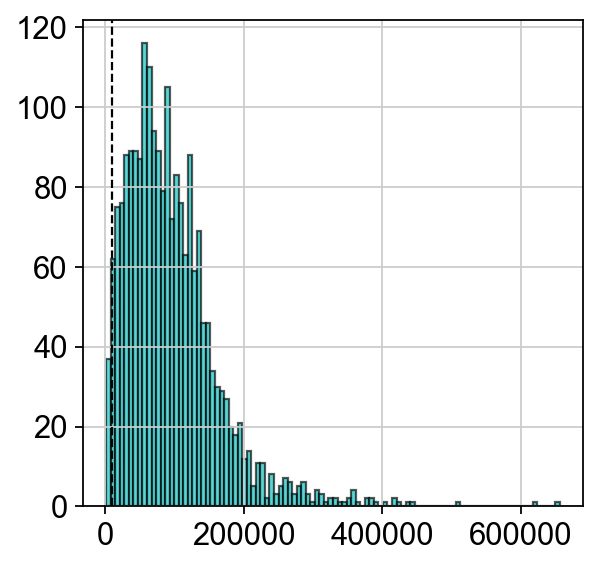

In [52]:
# visualize lower cutoff for filtering cells based on the number of genes
p = plt.hist(adata2.obs["n_counts_transcripts"], bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(10000, color='k', linestyle='dashed', linewidth=1)

In [47]:
adata2

View of AnnData object with n_obs × n_vars = 2102 × 54324
    obs: 'Sample', 'Mapped', 'ERCC', 'Endogenous', 'exp.', 'Experiment', 'Genome', 'Strain', 'ID.Individual', 'Tissue', 'Age', 'Sex', 'Ploidy', 'ERCC.dilution', 'Sequencer', 'column', 'row', 'exon_counts', 'intron_counts', 'rrna', 'inferred_cell_label', 'passing_QC', 'percentERCC', 'n_counts_raw', 'n_counts_transcripts', 'n_counts_ERCC', 'n_genes', 'n_counts'
    var: 'length', 'gene_name', 'chromosomes', 'start', 'end', 'biotype'

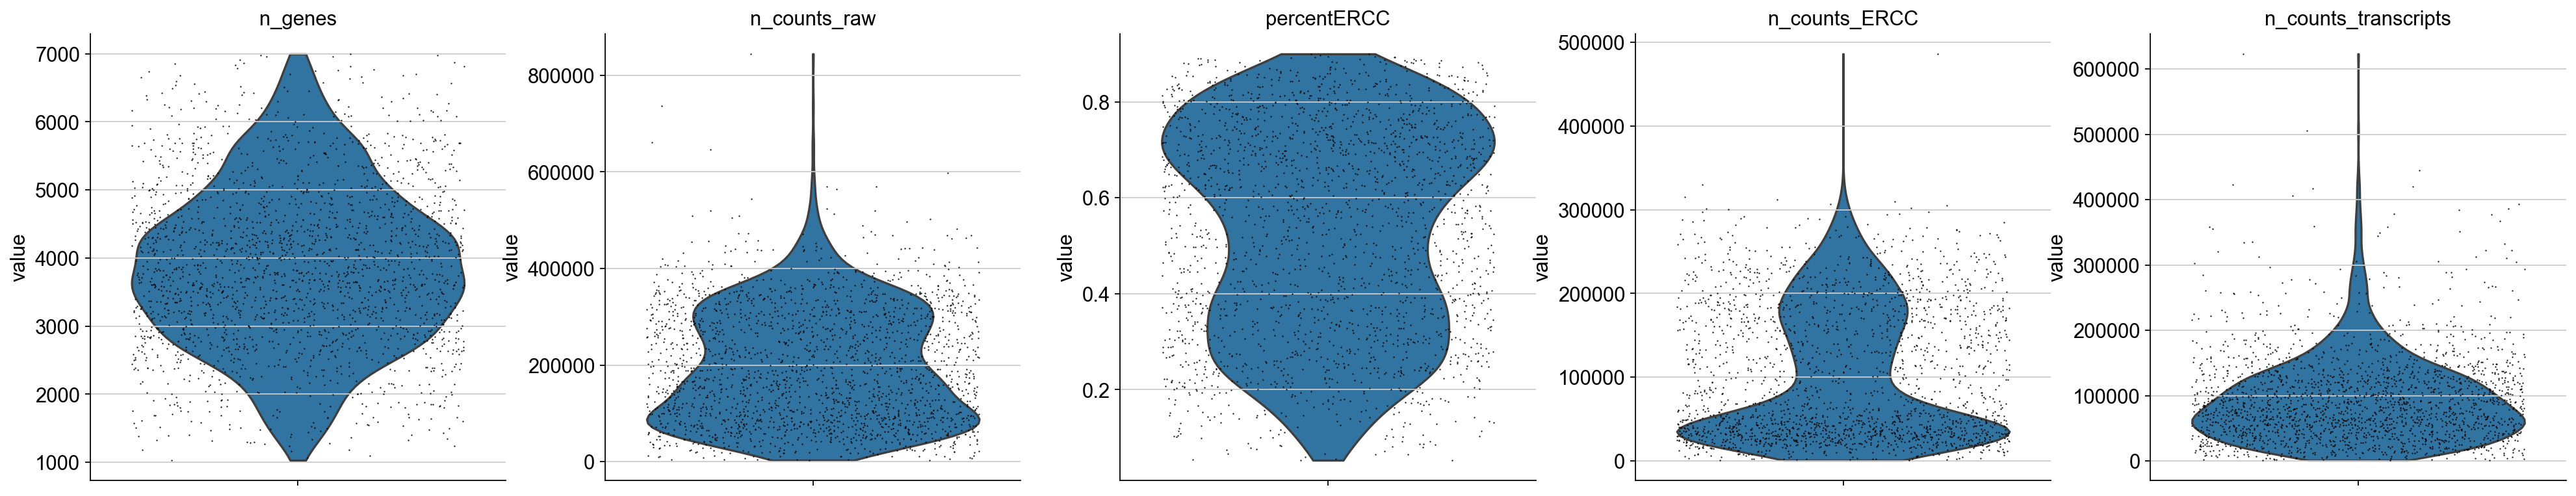

In [48]:
sc.pl.violin(adata2, ['n_genes', 'n_counts_raw', 'percentERCC', "n_counts_ERCC", "n_counts_transcripts"], jitter=0.4, multi_panel=True)

/Users/carmenrobinson/miniconda3/envs/singlecell/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


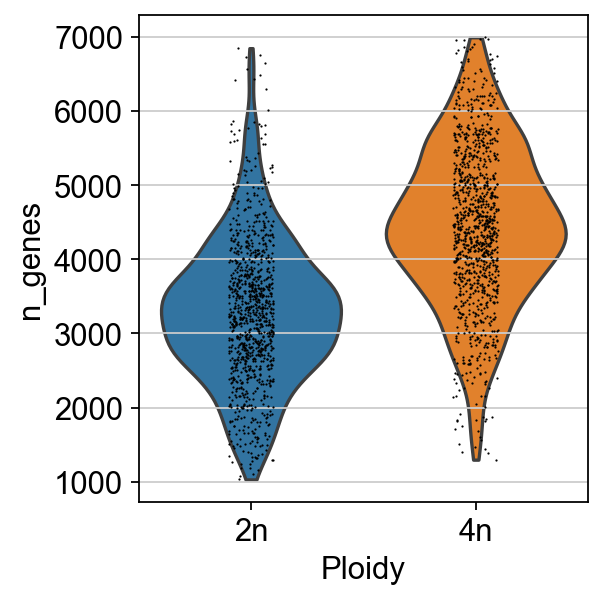

In [49]:
sc.pl.violin(adata2, "n_genes", groupby="Ploidy")

## Normalisation

#### Calculate ERCC size factors

In [ ]:
ERCC = []
for i in adata2.var_names:
    if i[0:3] != "ENS" and i[0:2] != "__":
        ERCC.append(i)

In [ ]:
# separate the matrix into the 2 dilutions and calculate the ERCC size factor separately 
adataHD = adata2[adata2.obs["ERCC.dilution"] == "1 in 300.000",:].copy()
adataLD = adata2[adata2.obs["ERCC.dilution"] == "1 in 100.000",:].copy()
adataHD.obs["ERCC_size_factor"] = np.sum(adataHD[:,ERCC].X, axis=1)/np.mean(np.sum(adataHD[:,ERCC].X, axis=1))
adataLD.obs["ERCC_size_factor"] = np.sum(adataLD[:,ERCC].X, axis=1)/np.mean(np.sum(adataLD[:,ERCC].X, axis=1))

In [ ]:
adata2 = ad.AnnData.concatenate(adataLD, adataHD)
new_names = adataLD.obs_names.append(adataHD.obs_names)
adata2.obs_names= new_names

In [ ]:
adata.obs.head()

#### Remove ERCC reads from the count matrix

In [ ]:
red_trans = []
for i in adata2.var_names:
    if i[0:3] == "ENS":
        red_trans.append(i) # endogeneous transcripts
        
adata2 = adata2[:,red_trans].copy()  

#### Store raw counts as layer in the AnnData object

In [ ]:
adata2.layers["counts"] = adata2.X.copy()

In [ ]:
adata2.obs.head()

#### Normalise by gene length and size factor

In [ ]:
# divide each column by transcript length (per 1kb)
for j in range(0, len(adata2.var)):
    adata2.X[:,j] = adata2.X[:,j]/(adata2.var["length"][j]/1000) 

adata2.obs['n_counts_TPM'] = adata2.X.sum(axis=1)

# sum the gene length-corrected counts per cell and divide by 10,000 times the ERCC size factor
adata2.obs['RPK_factor'] = adata2.obs['n_counts_TPM']/(adaxnta2.obs['ERCC_size_factor']*10000)

# divide each row (i.e. nucleus) by the size factor
for i in range(0,len(adata2)):
     adata2.X[i,:] = adata2.X[i,:]/adata2.obs["RPK_factor"][i]
adata2.obs['n_counts_TPM_norm'] = adata2.X.sum(axis=1)

In [ ]:
# plotting the normalized counts per cell
p = plt.hist(adata2.obs["n_counts_TPM_norm"], bins=100, color='c', edgecolor='k', alpha=0.65)

#### Store normalised counts as layer in the AnnData object

In [ ]:
adata2.layers["norm_counts"] = adata2.X.copy()

In [ ]:
sc.pl.violin(adata2, ['n_genes', 'n_counts_TPM'], jitter=.4, multi_panel=True)

#### Post-normalisation filtering: remove nuclei with > 50,000 length-normalized counts

In [ ]:
adata2 = adata2[adata2.obs["n_counts_TPM"] <= 50000,:].copy()

#### Remove technical replicates

In [ ]:
adata2 = adata2[adata2.obs["exp."] != "SNI-234(R2)",:].copy()
adata2 = adata2[adata2.obs["exp."] != "SNI-235(R2)",:].copy()

In [ ]:
adata2

# Carmens Modifications

In [ ]:
adata2.obs.rename(columns={"inferred_cell_label": "genes_expressed"}, inplace=True)

In [ ]:
adata2.obs.rename(columns={"genes_expressed" : "cell_type"}, inplace=True)

In [ ]:
adata2.write("/Users/carmenrobinson/Documents/GitHub/infercnvpy/docs/notebooks/adata_snRNAseq2")

In [ ]:
# mean and median transcript count after filtering and normalization
adata2.obs["mean_transcript_count_TPM"] = np.mean(adata2.X, axis=1)
adata2.var["mean_exp_TPM"] = np.mean(adata2.X, axis=0) ##skiped this 
adata2.var["median_exp_TPM"] = np.median(adata2.X, axis=0)

#### Logarithmize the count matrix and store as .raw and as additional layer

In [ ]:
sc.pp.log1p(adata2)

In [ ]:
adata2.raw = adata2
adata2.layers["raw"] = adata2.X

#### Store binarized matrix as additional layer

In [ ]:
adata3 = adata2.copy()
adata3.X[adata3.X != 0] = 1
adata2.layers["raw_bin"] = adata3.X

## Batch correction using combat (plates as covariate)

In [ ]:
sc.pp.combat(adata2, key="exp.")

## Visualisation

In [ ]:
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

In [ ]:
# PCA
sc.pl.pca_scatter(adata2, color=["Ploidy","n_genes", "ERCC.dilution", "exp."], wspace=0.4)

In [ ]:
# change colors for the ERCC dilution for the figures in the paper
adata2.uns["ERCC.dilution_colors"] = ["#054a41", "#c9bd6b"]

In [ ]:
# harmonize animal IDs
annot = []
for elem in adata2.obs["ID.Individual"]:
    if elem in ["16/036335","16/036335 (SNI-13)"]:
        annot.append("16/036335")
    elif elem in ["18/011304 (SNI-184)\xa0","AN18CUK011304"]:
        annot.append("18/011304")
    elif elem == "18/011303 (SNI-183)":
        annot.append("18/011303")
    elif elem in ["16/000798 (SNI-83)","16/000798 (SNI-83) ","AN16CUK000798"]:
        annot.append("16/000708")
    else:
        annot.append(elem)
adata2.obs["animal"] = annot

In [ ]:
# t-SNE
sc.tl.tsne(adata2, perplexity=30, n_pcs=15)
sc.pl.pca(adata2, color=["Ploidy", "n_genes", "exp.", "ERCC.dilution", "percentERCC", "n_counts_transcripts",
                         "n_counts_TPM_norm", "animal"],
           title=["Ploidy", "#genes", "Experiment", "ERCC dilution", "% of ERCC reads", 
                  "#raw transcript counts", "#normalized transcript counts","mouse_ID"],
           wspace=0.4)#, save="_SupplFig1_A_metadata.pdf")

## Save and load AnnData object for downstream analyses

In [ ]:
adata2.write('snRNAseq_mouse_hepatocytes_young_filtered_TPM_dec20.h5ad')

In [ ]:
adata = ad.read('snRNAseq_mouse_hepatocytes_young_filtered_TPM_dec20.h5ad')

In [ ]:
adata

## Cell type identification

In [ ]:
sc.tl.louvain(adata, resolution=1, key_added='louvainr1')
sc.pl.pca(adata, wspace=0.4, color=["louvainr1", "Ploidy","exp."])
sc.pl.tsne(adata, wspace=0.4, color=["louvainr1", "Ploidy","exp."])

In [ ]:
sc.tl.louvain(adata, resolution=0.5, key_added='louvainr05')

In [ ]:
# low resolution louvain clustering to separate hepatocytes from non-parenchymal cells
sc.tl.louvain(adata, resolution=0.2, key_added='louvainr02')
sc.pl.pca(adata, wspace=0.4, color=["louvainr05", "Ploidy","exp."])
sc.pl.tsne(adata, wspace=0.4, color=["louvainr02", "Ploidy","exp."])

In [ ]:
annot = []
for n in adata.obs['louvainr02']:
    if n == '0':
        annot.append('0')
    elif n == '1':
        annot.append('1')
adata.obs['low_res_ct'] = annot
del annot

In [ ]:
adata.uns["low_res_ct_colors"] = ["#686868", "#a9a9a9"]

In [ ]:
sc.pl.tsne(adata, color=["Ploidy","low_res_ct"])

#### Annotate the 4n that fall into the non-hepatocyte cluster

In [ ]:
missorted = []
for i in range(0, len(adata)):
    if adata.obs["low_res_ct"][i] == "0" and adata.obs["Ploidy"][i] == "2n":    
        missorted.append("2n_hepatocytes")
    elif adata.obs["low_res_ct"][i] == "0" and adata.obs["Ploidy"][i] == "4n":    
        missorted.append("4n_hepatocytes")
    elif adata.obs["low_res_ct"][i] == "1" and adata.obs["Ploidy"][i] == "2n": 
        missorted.append("2n_other_cluster")
    elif adata.obs["low_res_ct"][i] == "1" and adata.obs["Ploidy"][i] == "4n": 
        missorted.append("4n_other_cluster")
    else:
        missorted.append("2-2n")
adata.obs["clusters"] = missorted

#### Temporarily remove the hepatocytes from the matrix to cluster and annotate the non-parenchymal cells

In [ ]:
adata2 = adata[adata.obs["low_res_ct"] == "1",:].copy()

In [ ]:
sc.pp.pca(adata2)
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=25)
sc.tl.tsne(adata2, perplexity=20, n_pcs=15)

In [ ]:
sc.tl.louvain(adata2, resolution=1)

In [ ]:
sc.pl.tsne(adata2, color="louvain")

In [ ]:
marker_names_all = []
cell_type_list = []
with open("cell_type_markers.txt") as f:
    head = f.readline()
    for line in f:
        line = line.split("\t")
        marker_names_all.append(line[1][:-1])
        cell_type_list.append(line[0])      
cell_type_dict = {}
for name in list(set(cell_type_list)):
    cell_type_dict[name] = []
for i in range(0, len(cell_type_list)):
    cell_type_dict[cell_type_list[i]].append(marker_names_all[i])
gene_name_dict = {}
for i in range(0, len(adata.var)):
    gene_name_dict[adata2.var["gene_name"][i]] = adata2.var_names[i]
cell_type_id_dict = {}
for name in list(set(cell_type_list)):
    cell_type_id_dict[name] = []
cell_type_name_dict = {}
for name in list(set(cell_type_list)):
    cell_type_name_dict[name] = []
for name in list(set(cell_type_list)):
    item = cell_type_dict[name]
    for elem in item:
        if elem in gene_name_dict.keys():
            cell_type_id_dict[name].append(gene_name_dict[elem])
            cell_type_name_dict[name].append(elem) 

In [ ]:
cell_type_dict

In [ ]:
new_dict = {}
new_dict["Lymphocytes"] = []
for k, v in cell_type_id_dict.items():    
    if k in ['T-cells','B-cells','Plasma B-cells']:
        new_dict['Lymphocytes'].append(cell_type_id_dict[k])
    else:
        new_dict[k] = cell_type_id_dict[k]

In [ ]:
new_dict["Lymphocytes"] = [item for sublist in new_dict["Lymphocytes"] for item in sublist]

In [ ]:
new_dict

In [ ]:
# Endothelial cells
endothelial_id = cell_type_id_dict["Endothelial cells"]
endothelial_name = cell_type_name_dict["Endothelial cells"]
sc.pl.tsne(adata2, color=endothelial_id, title=endothelial_name, use_raw=True)

In [ ]:
# B-cells
bcell_id = cell_type_id_dict['B-cells']
bcell_name = cell_type_name_dict['B-cells']
sc.pl.tsne(adata2, color=bcell_id, title=bcell_name, use_raw=True)

In [ ]:
# Hepatobiliary cells
hepatob_id = cell_type_id_dict['Hepatobiliary cells']
hepatob_name = cell_type_name_dict['Hepatobiliary cells']
sc.pl.tsne(adata2, color=hepatob_id, title=hepatob_name, use_raw=True)

In [ ]:
# Kupffer and dendritic
kupffer_id = cell_type_id_dict['Kupffer and dendritic cells']
kupffer_name = cell_type_name_dict['Kupffer and dendritic cells']
sc.pl.tsne(adata2, color=kupffer_id, title=kupffer_name, use_raw=True)

In [ ]:
# Plasma B-cells
plasma_id = cell_type_id_dict['Plasma B-cells']
plasma_name = cell_type_name_dict['Plasma B-cells']
sc.pl.tsne(adata2, color=plasma_id, title=plasma_name, use_raw=True)

In [ ]:
# Stellate cells
stellate_id = cell_type_id_dict["Stellate cells"]
stellate_name = cell_type_name_dict["Stellate cells"]
sc.pl.tsne(adata2, color=stellate_id, title=stellate_name, use_raw=False)

In [ ]:
# T-cells
tcell_id = cell_type_id_dict["T-cells"]
tcell_name = cell_type_name_dict["T-cells"]
sc.pl.tsne(adata2, color=tcell_id, title=tcell_name, use_raw=False)

#### Overlap between marker genes and differentially expressed genes

In [ ]:
sc.tl.rank_genes_groups(adata2, groupby="louvain", n_genes=50)

In [ ]:
adata2.uns['log1p'].

In [ ]:
reduced_dict = new_dict.copy()
del reduced_dict["Hepatocytes"]

In [ ]:
import collections
od = collections.OrderedDict(sorted(reduced_dict.items()))

In [ ]:
adata.uns

In [ ]:
df = sc.tl.marker_gene_overlap(adata2, reference_markers=od)

In [ ]:
df

In [ ]:
sns.heatmap(df, cmap=sns.cubehelix_palette(37, start=.4, rot=-.75))

#### Annotate the cell types based on marker gene overlap:
- 0: Endothelial cells  
- 1: Plasma B-cells  
- 2, 6, 7: Hepatobiliary cells  
- 3: Expresses some lymphocyte markers (e.g. Herpud1) --> B-cells  
- 4: Kupffer and dendritic cells  
- 5: Expression of Bcl2 and Skap1 --> T-cells  
- 8: Stellate cells  
  
Epcam+ epithelial cells are defined by their expression of Epcam

In [ ]:
annot = []
for i in range(0, len(adata2)):
    if adata2[i,adata2.var["gene_name"]=="Epcam"].layers["counts"] > 50:
        annot.append("Epcam+ epithelial cells") 
    elif adata2.obs["louvain"][i] == "0":
        annot.append("Endothelial cells")
    elif adata2.obs["louvain"][i] == "1":
        annot.append("Plasma B-cells") 
    elif adata2.obs["louvain"][i] == "2":
        annot.append("Hepatobiliary cells") 
    elif adata2.obs["louvain"][i] == "3":
        annot.append("B-cells") 
    elif adata2.obs["louvain"][i] == "4":
        annot.append("Kupffer and dendritic cells")  
    elif adata2.obs["louvain"][i] == "5":
        annot.append("T-cells")   
    elif adata2.obs["louvain"][i] == "6":
        annot.append("Hepatobiliary cells")   
    elif adata2.obs["louvain"][i] == "7":
        annot.append("Hepatobiliary cells")    
    else:
        annot.append("Stellate cells")
adata2.obs["cell_type"] = annot         

In [ ]:
annot = []
for i in range(0, len(adata2)):
    if adata2[i,adata2.var["gene_name"]=="Epcam"].layers["counts"] > 50:
        annot.append("Hepatobiliary cells") 
    elif adata2.obs["louvain"][i] == "0":
        annot.append("Endothelial cells")
    elif adata2.obs["louvain"][i] == "1":
        annot.append("Lymphocytes") 
    elif adata2.obs["louvain"][i] == "2":
        annot.append("Hepatobiliary cells") 
    elif adata2.obs["louvain"][i] == "3":
        annot.append("Lymphocytes") 
    elif adata2.obs["louvain"][i] == "4":
        annot.append("Kupffer and dendritic cells")  
    elif adata2.obs["louvain"][i] == "5":
        annot.append("Lymphocytes")   
    elif adata2.obs["louvain"][i] == "6":
        annot.append("Hepatobiliary cells")   
    elif adata2.obs["louvain"][i] == "7":
        annot.append("Hepatobiliary cells")    
    else:
        annot.append("Stellate cells")
adata2.obs["broad_cell_type"] = annot       

#### Add the hepatocytes again

In [ ]:
annot = []
for elem in adata.obs_names.tolist():
    if elem in adata2.obs_names:
        annot.append(adata2[elem,:].obs["cell_type"][0])
    else:
        annot.append("Hepatocytes")
adata.obs["cell_type"] = annot

In [ ]:
annot = []
for elem in adata.obs_names.tolist():
    if elem in adata2.obs_names:
        annot.append(adata2[elem,:].obs["broad_cell_type"][0])
    else:
        annot.append("Hepatocytes")
adata.obs["broad_cell_type"] = annot

In [ ]:
annot = []
for idx, elem in enumerate(adata.obs["cell_type"]):
    if elem == "Hepatocytes" and adata.obs["Ploidy"][idx] == "2n":
        annot.append("2n Hepatocytes")
    elif elem == "Hepatocytes" and adata.obs["Ploidy"][idx] == "4n":
        annot.append("4n Hepatocytes")
    else:
        annot.append(elem)
adata.obs["cell_type1"] = annot        

In [ ]:
annot = []
for idx, elem in enumerate(adata.obs["broad_cell_type"]):
    if elem == "Hepatocytes" and adata.obs["Ploidy"][idx] == "2n":
        annot.append("2n Hepatocytes")
    elif elem == "Hepatocytes" and adata.obs["Ploidy"][idx] == "4n":
        annot.append("4n Hepatocytes")
    else:
        annot.append(elem)
adata.obs["broad_cell_type1"] = annot    

In [ ]:
sc.pl.tsne(adata, color="broad_cell_type1")

In [ ]:
adata.write("adata_export")

In [ ]:
small_marker_dict = {"B-cells":["Ildr1","Ebf1"],
                    "Endothelial cells":["Ptprb","Plekhg1","Stab2"],
                    "Epcam+ epithelial cells":["Epcam","Id3"],
                    "Hepatobiliary cells":["Ces3a","Filip1l","Sspn"], 
                    "Hepatocytes":["Cyp27a1","Ppara","Pck1"], 
                    "Kupffer and dentritic cells":["Clec4f","Cd5l","Slc40a1"],
                    "Plasma B-cells":["Mcmdc2","Hsf5"],
                    "Stellate cells":["Reln","Ecm1"],
                    "T-cells":["Bcl2","Gimap3"]}

small_marker_dict2 = {"Endothelial cells":["Plekhg1","Stab2","Ptprb"],
                    #"Epcam+ epithelial cells":["Epcam","Id3"],
                    "Hepatobiliary cells":["Cmss1","Sspn","Ces3a"], 
                    "Hepatocytes":["Cyp27a1","Ppara","Pck1"], 
                    "Kupffer and dentritic cells":["Clec4f","Cd5l","Slc40a1"],
                    "Lymphocytes":["Gata3","Skap1","Bcl2"],
                    "Stellate cells":["Colec11","Reln","Ecm1"]}

small_marker_dict2 = {"Hepatocytes":["Cyp27a1","Ppara","Pck1"],
                      "Hepatobiliary cells":["Cmss1","Sspn","Epcam"],
                      "Endothelial cells":["Plekhg1","Stab2","Ptprb"],
                      "Kupffer and dentritic cells":["Clec4f","Cd5l","Slc40a1"],
                      "Lymphocytes":["Skap1","Bcl2","Gata3"],
                      "Stellate cells":["Reln","Ecm1","Ldb2"]}

cols = ['#17becf','#aec7e8','#4EB265','#DC050C','#aa40fc','#8c564b','#332288','#FFAABB','#b5bd61']
cols = ['#ade8e3','#17becf','#332288','#8c564b','#DC050C','#FFAABB']

sc.pl.stacked_violin(adata, gene_symbols="gene_name", groupby="broad_cell_type2", var_names=small_marker_dict2,
                    row_palette=cols, standard_scale="var", layer="raw", log=False, scale="count",
                    save="_Figure1_D_new_aggregated_20210309.pdf")

In [ ]:
adata.uns["broad_cell_type_colors"] = ["#DC050C","#8c564b","#332288","#FFAABB","#ade8e3","#17becf"]
adata.uns["broad_cell_type2_colors"] = ["#332288","#8c564b","#DC050C","#FFAABB","#ade8e3","#17becf"]

In [ ]:
sc.pl.tsne(adata, color="broad_cell_type2", save="_Figure1_D_new_aggregated_20210309.pdf")

In [ ]:
sc.pl.tsne(adata, color=["Cyp27a1","Cmss1","Stab2","Clec4f","Skap1","Reln",
                         "Pck1","Sspn","Ptprb","Cd5l","Bcl2","Ecm1",
                         "Ppara","Epcam","Plekhg1","Slc40a1","Gata3","Ldb2"], gene_symbols="gene_name",
          ncols=6, save="_Figure1_E_new_aggregated_markers_20210309.pdf")

In [ ]:
cf.cell_compo_table(adata, "broad_cell_type", "broad_cell_type")

In [ ]:
86/1649

In [ ]:
179/1649

In [ ]:
69/1649

In [ ]:
216/1649

In [ ]:
38/1649

In [ ]:
adata3 = adata.copy()
adata3.var_names = adata.var["gene_name"]
adata3.raw = adata3

In [ ]:
sc.tl.rank_genes_groups(adata3, groupby="broad_cell_type")

In [ ]:
adata3.uns["rank_genes_groups"]

In [ ]:
annot = []
for elem in adata.obs["broad_cell_type"]:
    if elem == "Hepatocytes":
        annot.append("01 Hepatocytes")
    elif elem == "Lymphocytes":
        annot.append("05 Lymphocytes")
    elif elem == "Endothelial cells":
        annot.append("03 Endothelial cells")
    elif elem == "Hepatobiliary cells":
        annot.append("02 Hepatobiliary cells")
    elif elem == "Kupffer and dendritic cells":
        annot.append("04 Kupffer and dendritic cells")
    elif elem == "Stellate cells":
        annot.append("06 Stellate cells")
adata.obs["broad_cell_type2"] = annot

In [ ]:
annot = []
for elem in adata.obs["cell_type"]:
    if elem == "Hepatocytes":
        annot.append("01 Hepatocytes")
    elif elem == "B-cells":
        annot.append("09 B-cells")
    elif elem == "Endothelial cells":
        annot.append("03 Endothelial cells")
    elif elem == "Epcam+ epithelial cells":
        annot.append("04 Epcam+ epithelial cells")
    elif elem == "Hepatobiliary cells":
        annot.append("02 Hepatobiliary cells")
    elif elem == "Kupffer and dendritic cells":
        annot.append("05 Kupffer and dendritic cells")
    elif elem == "Plasma B-cells":
        annot.append("07 Plasma B-cells")
    elif elem == "Stellate cells":
        annot.append("06 Stellate cells")
    else:
        annot.append("08 T-cells")
adata.obs["cell_type2"] = annot

In [ ]:
# Data
df = cf.cell_compo_table(adata,"broad_cell_type2", "broad_cell_type2")

In [ ]:
df1 = [i / 1649 * 100 for i in df['All']]

In [ ]:
df2 = pd.DataFrame()
df2["values"] = df1[:-1]
df2.index = df.index[:-1]

In [ ]:
color = ['#332288', '#8c564b', '#DC050C', '#FFAABB', '#ade8e3',
       '#17becf']
df2.T.plot(kind='bar', stacked=True, color=color)
plt.xticks(np.arange(1), "")
plt.xlabel("Percentage cell types")

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("barplot_percentages_Figure1_D_new_aggregated_20210309.pdf", bbox_inches="tight")

#### Preprocessing for the heatmap in R

In [ ]:
adatar = ad.read("adata_rRNA.h5ad")

In [ ]:
rrna = []
for elem in adata.var_names.tolist():
    if elem in adatar.var_names.tolist():
        rrna.append("yes")
    else:
        rrna.append("no")
adata.var["rrna"] = rrna   

In [ ]:
adatam = adata[:,adata.var["rrna"] == "no"]

In [ ]:
adata1 = adatam[adatam.obs["cell_type"] == "Hepatocytes",:].copy()
sc.pp.subsample(adata1, n_obs=40, random_state=1)
adata2 = adatam[adatam.obs["cell_type"] == "Hepatobiliary cells",:].copy()
sc.pp.subsample(adata2, n_obs=40, random_state=1)
adata3 = adatam[adatam.obs["cell_type"] == "Endothelial cells",:].copy()
sc.pp.subsample(adata3, n_obs=40, random_state=1)
adata4 = adatam[adatam.obs["cell_type"] == "Kupffer and dendritic cells",:].copy()
sc.pp.subsample(adata4, n_obs=40, random_state=1)
adata5 = adatam[adatam.obs["cell_type"] == "B-cells",:].copy()
sc.pp.subsample(adata5, n_obs=40, random_state=1)
adata6 = adatam[adatam.obs["cell_type"] == "Plasma B-cells",:].copy()
sc.pp.subsample(adata6, n_obs=40, random_state=1)
adata7 = adatam[adatam.obs["cell_type"] == "T-cells",:].copy()
sc.pp.subsample(adata7, n_obs=40, random_state=1)
adata8 = adatam[adatam.obs["cell_type"] == "Epcam+ epithelial cells",:].copy()
sc.pp.subsample(adata8, n_obs=12, random_state=1)
adata9 = adatam[adatam.obs["cell_type"] == "Stellate cells",:].copy()
sc.pp.subsample(adata9, n_obs=38, random_state=1)

In [ ]:
adata1 = adatam[adatam.obs["broad_cell_type2"] == "01 Hepatocytes",:].copy()
sc.pp.subsample(adata1, n_obs=40, random_state=1)
adata2 = adatam[adatam.obs["broad_cell_type2"] == "02 Hepatobiliary cells",:].copy()
sc.pp.subsample(adata2, n_obs=40, random_state=1)
adata3 = adatam[adatam.obs["broad_cell_type2"] == "03 Endothelial cells",:].copy()
sc.pp.subsample(adata3, n_obs=40, random_state=1)
adata4 = adatam[adatam.obs["broad_cell_type2"] == "04 Kupffer and dendritic cells",:].copy()
sc.pp.subsample(adata4, n_obs=40, random_state=1)
adata5 = adatam[adatam.obs["broad_cell_type2"] == "05 Lymphocytes",:].copy()
sc.pp.subsample(adata5, n_obs=40, random_state=1)
adata9 = adatam[adatam.obs["broad_cell_type2"] == "06 Stellate cells",:].copy()
sc.pp.subsample(adata9, n_obs=38, random_state=1)

In [ ]:
adataS = adata1.concatenate(adata2, adata3, adata4, adata5, adata9)

In [ ]:
sc.tl.rank_genes_groups(adataS, groupby="broad_cell_type2", n_genes=20, layer="raw", use_raw=False)

In [ ]:
unsup_markers = []
for elem in list(adataS.uns["rank_genes_groups"]["names"]['01 Hepatocytes'])[0:12]:
    unsup_markers.append(elem)
for elem in list(adataS.uns["rank_genes_groups"]["names"]['02 Hepatobiliary cells'])[0:12]:
    unsup_markers.append(elem)
for elem in list(adataS.uns["rank_genes_groups"]["names"]['03 Endothelial cells'])[0:12]:
    unsup_markers.append(elem)
for elem in list(adataS.uns["rank_genes_groups"]["names"]['04 Kupffer and dendritic cells'])[0:12]:
    unsup_markers.append(elem)
for elem in list(adataS.uns["rank_genes_groups"]["names"]['05 Lymphocytes'])[0:12]:
    unsup_markers.append(elem)    
for elem in list(adataS.uns["rank_genes_groups"]["names"]['06 Stellate cells'])[0:12]:
    unsup_markers.append(elem)    

In [ ]:
adatax = adataS[:,unsup_markers]

In [ ]:
np.savetxt("ct_mat_unsup_markers_for_heatmap_in_R.txt", adatax.layers["raw"], delimiter="\t", fmt='%.8f')
adatax.write_csvs("metadata_for_heatmap_in_R/")

## Cell cycle analysis

In [ ]:
import rpy2.rinterface
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
%load_ext rpy2.ipython
anndata2ri.activate()

In [ ]:
data_mat = adata.X.T
gnames = adata.var_names.tolist()
cnames = adata.obs_names.tolist()

In [ ]:
%%R
.libPaths( c( .libPaths(), "/home/maria/R/x86_64-pc-linux-gnu-library/4.0") )
library(scran)

In [ ]:
%%R -i data_mat -i gnames -i cnames -o phases -o scores

# cell cycle analysis using cyclone
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))

rownames(data_mat) <- gnames
colnames(data_mat) <- cnames

score_list <- cyclone(data_mat, mm.pairs, gene.names=rownames(data_mat), iter=1000, min.iter=100, min.pairs=50)#,  BPPARAM=bpparam(), verbose=FALSE)

phases <- score_list$phases
scores <- score_list$scores

In [ ]:
adata.obs["cyclone_phases"] = phases
adata.obs["score_G1"] = scores["G1"].tolist()
adata.obs["score_S"] = scores["S"].tolist()
adata.obs["score_G2M"] = scores["G2M"].tolist()

In [ ]:
adata.uns["cyclone_phases_colors"] = ['#505050', '#bc086b', '#0af9ea']

In [ ]:
sc.pl.tsne(adata, color=["cyclone_phases","Ploidy", "score_S", "score_G1", "score_G2M"])

In [ ]:
cf.cell_compo_table(adata, "clusters", "cyclone_phases")

In [ ]:
cf.cell_compo_table(adata,"cell_type", "cyclone_phases")

In [ ]:
# Data
df = cf.cell_compo_table(adata,"cyclone_phases", "cell_type")
r = np.arange(10)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['G1'], df['G2M'], df['S'])]

G1 = [i / j * 100 for i,j in zip(df['G1'], totals)]
G2M = [i / j * 100 for i,j in zip(df['G2M'], totals)]
S = [i / j * 100 for i,j in zip(df['S'], totals)]

# plot
barWidth = 0.85
names = ('Hepatocytes', 'B-cells', 'Endothelial cells', 'Epcam+ epithelial cells',
         'Hepatobiliary cells', 'Kupffer and dendritic cells', 'Plasma B-cells',
         'Stellate cells', 'T-cells')

# Create bars
plt.bar(r, G1, width=barWidth, label="G1", color=("#505050"))
plt.bar(r, G2M, bottom=G1, width=barWidth, label="G2M", color=("#bc086b"))
plt.bar(r, S, bottom=[i+j for i,j in zip(G1, G2M)], width=barWidth, label="S", color=("#0af9ea"))


    
# Custom x axis
plt.xticks(r, names)
#plt.xlabel("group")
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Show graphic
plt.show()

## Plotting transcription factors and disease markers

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Hepatocytes"]

In [ ]:
# transcription factors
tf = ["Hnf4a", "Ppara", "Mlxipl", "Cebpa", "Rxra", "Nr1i2", "Nr1i3", "Nr1h4"]

tf_name = []
tf_id = []
index = 0
for n in adata.var["gene_name"].tolist():
    if n in tf:
        tf_name.append(n)
        tf_id.append(adata.var_names[index])
    index += 1
#adata2 = adata[:,nmarker_id].copy()  
sc.pl.tsne(adata, color=tf_id, title=tf_name)

In [ ]:
sc.pl.dotplot(adata1, var_names=tf_name, gene_symbols="gene_name", groupby="cell_type1",
              color_map="Reds", mean_only_expressed=True, layer="raw",
              dot_min=0, dot_max=0.5)

In [ ]:
disease_markers = ["Akr1d1","Vegfa","Lifr","Yap1","Tead1","Nrp1","Igfbp1","Fstl1","Serpinc1","Bicc1"]

marker_name = []
marker_id = []
index = 0
for n in adata.var["gene_name"].tolist():
    if n in disease_markers:
        marker_name.append(n)
        marker_id.append(adata.var_names[index])
    index += 1

In [ ]:
sc.pl.tsne(adata, color=marker_name, gene_symbols="gene_name")

In [ ]:
sc.pl.dotplot(adata, var_names=marker_name, gene_symbols="gene_name", groupby="broad_cell_type1",
              color_map="coolwarm", mean_only_expressed=True, layer="raw",
              dot_min=0, dot_max=1, save="_Figure2_F_disease_markers_new_aggregated_20210309.pdf")

In [ ]:
sc.pl.stacked_violin(adata, var_names=marker_name, gene_symbols="gene_name", groupby="broad_cell_type1",
                     swap_axes=True, standard_scale="var", figsize=(5,5),
                     save="_SupplFig_5_disease_markers_new_aggregated_20210309.pdf")

## Differential expression analysis

#### Between cell types

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", n_genes=19258, method="t-test")

In [ ]:
dict_genes = adata.uns["rank_genes_groups"].copy()

In [ ]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.var[elem+"_mean"] = np.mean(adata[adata.obs["cell_type"] == elem,:].layers["norm_counts"], axis=0)
    adata.var[elem+"_n_cells"] = np.sum(adata[adata.obs["cell_type"] == elem,:].layers["norm_counts"] > 0, axis=0)
    dataframe.index = dataframe[elem+"_gene"]
    adata.var[elem+"_log2FC"] = dataframe[elem+"_logfoldchange"]
    adata.var[elem+"_pvals_adj"] = dataframe[elem+"_pval_adj"]

In [ ]:
changes = []
for j in range(0, len(adata.var)):
    if adata.var["Hepatocytes_log2FC"][j] > 0.5 and adata.var["Hepatocytes_pvals_adj"][j] < 0.05:
        changes.append("up_Hepatocytes")
    elif adata.var["Hepatobiliary cells_log2FC"][j] > 0.5 and adata.var["Hepatobiliary cells_pvals_adj"][j] < 0.05:
        changes.append("up_Hepatobiliary")    
    elif adata.var["Endothelial cells_log2FC"][j] > 0.5 and adata.var["Endothelial cells_pvals_adj"][j] < 0.05:
        changes.append("up_Endothelial")
    elif adata.var["Endothelial cells_log2FC"][j] > 0.5 and adata.var["Endothelial cells_pvals_adj"][j] < 0.05:
        changes.append("up_Endothelial")
    elif adata.var["Kupffer and dendritic cells_log2FC"][j] > 0.5 and adata.var["Kupffer and dendritic cells_pvals_adj"][j] < 0.05:
        changes.append("up_Kupffer")
    elif adata.var["B-cells_log2FC"][j] > 0.5 and adata.var["B-cells_pvals_adj"][j] < 0.05:
        changes.append("up_Bcell")    
    elif adata.var["Epcam+ epithelial cells_log2FC"][j] > 0.5 and adata.var["Epcam+ epithelial cells_pvals_adj"][j] < 0.05:
        changes.append("up_EpcamEpithelial") 
    elif adata.var["Plasma B-cells_log2FC"][j] > 0.5 and adata.var["Plasma B-cells_pvals_adj"][j] < 0.05:
        changes.append("up_PlasmaBcell")   
    elif adata.var["Stellate cells_log2FC"][j] > 0.5 and adata.var["Stellate cells_pvals_adj"][j] < 0.05:
        changes.append("up_Stellate")
    elif adata.var["T-cells_log2FC"][j] > 0.5 and adata.var["T-cells_pvals_adj"][j] < 0.05:
        changes.append("up_Tcell")      
    else:
        changes.append("none")
        
adata.var["changes_cell_types"] = changes 

#### Between 2n and 4n hepatocytes

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Hepatocytes",:].copy()

In [ ]:
sc.pl.violin(adata1, "n_genes", groupby="Ploidy")

In [ ]:
np.median(adata1[adata1.obs["Ploidy"] == "4n"].obs["n_genes"])/np.median(adata1[adata1.obs["Ploidy"] == "2n"].obs["n_genes"])

In [ ]:
sc.pl.scatter(adata1, x='n_counts_TPM', y='n_genes', color='Ploidy')

In [ ]:
sc.tl.rank_genes_groups(adata1, groupby="cell_type1", n_genes=19258, method="t-test")

In [ ]:
dict_genes = adata1.uns["rank_genes_groups"].copy()

In [ ]:
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe = pd.DataFrame(df)        
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata.var[elem+"_mean"] = np.mean(adata[adata.obs["cell_type1"] == elem,:].layers["norm_counts"], axis=0)
    #adata.var[elem+"_sum"] = np.sum(adata[adata.obs["cell_type"] == elem,:].layers["norm_counts"], axis=0)
    adata.var[elem+"_n_cells"] = np.sum(adata[adata.obs["cell_type1"] == elem,:].layers["norm_counts"] > 0, axis=0)
    dataframe.index = dataframe[elem+"_gene"]
    adata.var[elem+"_log2FC"] = dataframe[elem+"_logfoldchange"]
    adata.var[elem+"_pvals_adj"] = dataframe[elem+"_pval_adj"]

In [ ]:
changes = []
for j in range(0, len(adata.var)):
    if adata.var["2n Hepatocytes_log2FC"][j] > 0.5 and adata.var["2n Hepatocytes_pvals_adj"][j] < 0.05:
        changes.append("up_2n")
    elif adata.var["4n Hepatocytes_log2FC"][j] > 0.5 and adata.var["4n Hepatocytes_pvals_adj"][j] < 0.05:
        changes.append("up_4n")
    else:
        changes.append("none")
        
adata.var["changes_hep"] = changes      

In [ ]:
DE_dict = {}
for elem in list(set(adata.obs["cell_type"])): # to get the 2n and 4n hepatocytes, re-run with "cell_type1"
    DE_dict[elem+"_up"] = 0
    DE_dict[elem+"_down"] = 0
    outfile_up = open("differential_expression/up_"+elem, "w")
    outfile_down = open("differential_expression/down_"+elem, "w")
    for j in range(0,len(adata.var)):
        if adata.var[elem+"_log2FC"][j] > 0.5 and adata.var[elem+"_pvals_adj"][j] < 0.05:
            DE_dict[elem+"_up"] += 1
            outfile_up.write(adata.var_names[j])
            outfile_up.write("\n")
        elif adata.var[elem+"_log2FC"][j] < -0.5 and adata.var[elem+"_pvals_adj"][j] < 0.05:
            DE_dict[elem+"_down"] += 1
            outfile_down.write(adata.var_names[j])
            outfile_down.write("\n")
    outfile_up.close()
    outfile_down.close()

#### Where does the higher number of genes in 4n come from?

In [ ]:
# look for genes that are detected in 4n but not expressed in 2n
varannot= []
for i in range(0, len(adata.var)):
    if adata.var["4n Hepatocytes_mean"][i] > 0 and adata.var["2n Hepatocytes_n_cells"][i] == 0:
        varannot.append("not detected")
    else:
        varannot.append("detected")  
adata1.var["detected"] = varannot

In [ ]:
df = pd.DataFrame()
df["Mean expression"] = adata.var["4n Hepatocytes_mean"]
df["status"] = varannot
df["genes"] = " "

In [ ]:
df = df[df["Mean expression"] != 0] # remove the 1 gene that is neither in 2n nor 4n

In [ ]:
cols = {"detected" : '0.9', "not detected" : '#be073f'}
g = sns.catplot(data=df.sort_values("status"), x="genes", y="Mean expression", hue="status", palette=cols, kind="strip", 
                 alpha=0.5, dodge=False, marker="X")
plt.yscale("log")

#### Plotting DEGs between 2n and 4n

In [ ]:
cols = []
for elem in adata.var["changes_hep"]:
    if elem == "up_2n":
        cols.append("#1f77b4")
    elif elem == "up_4n":
        cols.append("#ff7f0e")
    else:
        cols.append("0.75")

In [ ]:
# number of genes per ploidy level
genes2n = pd.DataFrame()
genes4n = pd.DataFrame()
adata2n = adata[adata.obs["cell_type"] == "2n Hepatocytes"].copy()
adata4n = adata[adata.obs["cell_type"] == "4n Hepatocytes"].copy()

genes2n["n_genes_2n"] = adata2n.obs["n_genes"]
genes4n["n_genes_4n"] = adata4n.obs["n_genes"]

In [ ]:
# small data frame with means and number of cells in which a gene is expressed
df = pd.DataFrame()
df["mean_2n"] = adata.var["2n Hepatocytes_mean"]
df["mean_4n"] = adata.var["4n Hepatocytes_mean"]
df["mean_hep"] = adata.var["Hepatocytes_mean"]
df["logFC_2n"] = adata.var["2n Hepatocytes_log2FC"]
df["logFC_4n"] = adata.var["4n Hepatocytes_log2FC"]
df["cells_2n"] = adata.var["2n Hepatocytes_n_cells"]
df["cells_4n"] = adata.var["4n Hepatocytes_n_cells"]
df["changes"] = adata.var["changes_hep"]
df.index = adata.var.index

In [ ]:
# for better visualisation, remove lowly and highly expressed genes
df1 = df[df["mean_2n"] > 0.1]
df1 = df1[df1["mean_2n"] < 100]
df2 = df1[df1["mean_4n"] > 0.1]
df2 = df2[df2["mean_4n"] < 100]

In [ ]:
cols = {"none" : '0.8', "up_2n" : '#1f77b4', "up_4n" : "#ff7f0e"}
for i, j in df2.groupby('changes'):
    print(i)
    plt.scatter(j['mean_hep'], j['logFC_2n'], c=cols[i], alpha=0.2, marker="x")
    plt.scatter(j['mean_hep'], j['logFC_2n'], c=cols[i], alpha=0.2, marker="x")
    plt.scatter(j['mean_hep'], j['logFC_2n'], c=cols[i], alpha=0.2, marker="x")
    plt.xscale("log")

In [ ]:
up2n = df[df["changes"] == "up_2n"]
up4n = df[df["changes"] == "up_4n"]

In [ ]:
df3 = df2[df2["changes"] != "none"]

In [ ]:
from scipy.stats import gaussian_kde

# colors for scatter plot
cols = []
for elem in df3["changes"]:
    if elem == "up_2n":
        cols.append("#1f77b4")
    elif elem == "up_4n":
        cols.append("#ff7f0e")
    else:
        cols.append("0.85")

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.02


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.22, height]


# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)

ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_x = plt.axvline(up2n["cells_2n"].mean(), color='k', linestyle='dashed', linewidth=1.5)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
ax_y = plt.axhline(up4n["cells_4n"].mean(), color='k', linestyle='dashed', linewidth=1.5)


# the scatter plot:
ax_scatter.scatter(x=df3["cells_2n"], y=df3["cells_4n"], c=cols, alpha=0.5, marker="x")

# now determine nice limits by hand:
binwidth = 10
lim = np.ceil(np.abs([df3["cells_2n"], df3["cells_4n"]]).max() / binwidth) * binwidth
ax_scatter.set_xlim((0, lim))
ax_scatter.set_ylim((0, lim))

bins = np.arange(0, lim + binwidth, binwidth)
dist_space = np.linspace(0, lim, 1000)

# using gaussian_kde to get a density plot instead of histogram
density2n = gaussian_kde(up2n["cells_2n"])
density4n = gaussian_kde(up4n["cells_4n"], bw_method=.1)


ax_histx.plot(dist_space, density2n(dist_space), c="#1f77b4")
ax_x
ax_histy.plot(density4n(dist_space), dist_space, c="#ff7f0e")
ax_y

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(ax_histx.get_ylim())
ax_histy.set_xticks(ticks=[0.000,0.002,0.004,0.006])
ax_histy.set_xticklabels(labels=[0.000,None,None,0.006])

#### Gene set enrichment analysis on top 100 DEGs

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type1', n_genes=100, use_raw=True, 
                        groups=["4n Hepatocytes"], reference='2n Hepatocytes', method="t-test")

In [ ]:
plt.rcParams['figure.figsize']=(10,8) #rescale figures
genes = adata.uns["rank_genes_groups"]["names"]["4n Hepatocytes"].tolist()   

    
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = gprofiler(genes, organism='mmusculus')
gp = gp[gp["domain"] == "BP"]

gp_enrichment = gp.sort_values('p.value').iloc[:,[2,3,5,6,11]]
gp_enrichment['name']= gp_enrichment['term.name'].copy()
gp_enrichment['p_value']= gp_enrichment['p.value'].copy()
gp_enrichment['intersection_size']= gp_enrichment['overlap.size'].copy()
del gp_enrichment['term.name'], gp_enrichment['overlap.size'], gp_enrichment['p.value']
cf.plot_enrich(gp_enrichment, save='GO_4n_vs_2n_top100.pdf')

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type1', n_genes=100, use_raw=True, 
                        groups=["2n Hepatocytes"], reference='4n Hepatocytes', method="t-test")

In [ ]:
plt.rcParams['figure.figsize']=(10,8) #rescale figures
genes = adata.uns["rank_genes_groups"]["names"]["2n Hepatocytes"].tolist()   

    
#Interpretation of differentially expressed genes in paneth cells - g:profiler
gp = gprofiler(genes, organism='mmusculus')
gp = gp[gp["domain"] == "BP"]

gp_enrichment = gp.sort_values('p.value').iloc[:,[2,3,5,6,11]]
gp_enrichment['name']= gp_enrichment['term.name'].copy()
gp_enrichment['p_value']= gp_enrichment['p.value'].copy()
gp_enrichment['intersection_size']= gp_enrichment['overlap.size'].copy()
del gp_enrichment['term.name'], gp_enrichment['overlap.size'], gp_enrichment['p.value']
cf.plot_enrich(gp_enrichment, save='GO_2n_vs_4n_top100.pdf')

## Changes in distribution

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Hepatocytes",:]

In [ ]:
import scipy

In [ ]:
statvals = []
pvals = []
for j in range(0, len(adata1.var)):
    stat, p = scipy.stats.ks_2samp(adata1.X[adata1.obs["Ploidy"] == "2n",j],
                                   adata1.X[adata1.obs["Ploidy"] == "4n",j],
                                   mode="exact")
    statvals.append(stat)
    pvals.append(p)

In [ ]:
adata.var["distribution_changes"] = statvals
adata.var["dist_changes_pvalues"] = pvals

In [ ]:
sig = []
for idx, elem in enumerate(adata.var["dist_changes_pvalues"]):
    if elem < 0.05 and adata.var["distribution_changes"][idx] > 0.15:
        sig.append("yes")
    else:
        sig.append("no")
adata.var["sig_dist_change"] = sig

## Violin plots for metabolic marker genes

In [ ]:
markers = ["Cyp2d26", "Cyp2d9", "Cyp3a25", "Cyp2e1","Cyp27a1"]
sc.pl.stacked_violin(adata1, var_names=markers, gene_symbols="gene_name", groupby="Ploidy",
                     figsize=(1.5,4),
                     swap_axes=True,
                     cmap="Blues",
                     standard_scale="var")

## Coefficient of variation

In [ ]:
# change the figure configurations back to the initial settings
sc.settings.set_figure_params(dpi=80)

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

In [ ]:
adata1 = adata.copy()

In [ ]:
adata1.var["mean_norm_counts"] = np.mean(adata1.layers["raw"], axis=0)
adata1.var["mean_norm_counts_log"] = np.mean(adata1.X, axis=0)

In [ ]:
#adata1 = adata1[:,adata1.var["changes_hep"] == "none"]

In [ ]:
# remove genes with low mean expression
adata1 = adata1[:,adata1.var["mean_norm_counts"] > 0.25].copy()

In [ ]:
#df = pd.DataFrame()
#df2 = pd.DataFrame()
#df3 = pd.DataFrame()
#for elem in list(set(adata.obs["cell_type"])):
#    print(elem)
#    adata1.var["mean_"+elem] = np.mean(adata1[adata1.obs["cell_type"] == elem,:].layers["norm_counts"], axis=0)
#    adata1.var["CV_"+elem] = np.sqrt(np.exp(np.std(adata1[adata1.obs["cell_type"] == elem,:].X, axis=0)**2)-1)
#    df["CV_"+elem] = np.sqrt(np.exp(np.std(adata1[adata1.obs["cell_type"] == elem,:].X, axis=0)**2)-1)
#    print(np.median(df["CV_"+elem]))
#    df3["CV_"+elem] = np.std(adata1[adata1.obs["cell_type"] == elem,:].layers["counts"], axis=0)/np.mean(adata1[adata1.obs["cell_type"] == elem,:].layers["counts"], axis=0)
#    df2["mean_"+elem] = np.mean(adata1[adata1.obs["cell_type"] == elem,:].layers["raw"], axis=0)

In [ ]:
#df1 = df.unstack().reset_index() 

In [ ]:
# use same colors as in the tSNE
#cols = {"CV_Hepatocytes":'#332288', "CV_B-cells":'#4EB265', "CV_Endothelial cells":'#DC050C', 
#        "CV_Epcam+ epithelial cells":'#aa40fc', "CV_Hepatobiliary cells":'#8c564b',
#        "CV_Kupffer and dendritic cells":'#FFAABB', "CV_Plasma B-cells":'#b5bd61', 
#        "CV_Stellate cells":'#17becf', "CV_T-cells":'#aec7e8'}
#p = sns.boxplot(x="level_0", y=0, data=df1, palette=cols)
#p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
#box = p.get_position()
#p.set_position([box.x0, box.y0, box.width * 1.5, box.height * 1.2])
#plt.yscale("log")

#### CV between 2n and 4n hepatocytes

In [ ]:
df = pd.DataFrame()
df2 = pd.DataFrame()
#df3 = pd.DataFrame()
for elem in ['2n Hepatocytes', '4n Hepatocytes']:
    adata1.var["mean_"+elem] = np.mean(adata1[adata1.obs["cell_type1"] == elem,:].layers["norm_counts"], axis=0)
    adata1.var["CV_"+elem] = np.sqrt(np.exp(np.std(adata1[adata1.obs["cell_type1"] == elem,:].X, axis=0)**2)-1)
    df["CV_"+elem] = np.sqrt(np.exp(np.std(adata1[adata1.obs["cell_type1"] == elem,:].X, axis=0)**2)-1)
    #df3["CV_"+elem] = np.std(adata1[adata1.obs["cell_type1"] == elem,:].X, axis=0)/np.mean(adata1[adata1.obs["cell_type1"] == elem,:].X, axis=0)
    df2["mean_"+elem] = np.mean(adata1[adata1.obs["cell_type1"] == elem,:].layers["raw"], axis=0)

In [ ]:
df1 = df.unstack().reset_index() 

In [ ]:
cols = {"CV_2n Hepatocytes":'#1f77b4', "CV_4n Hepatocytes":'#ff7f0e'}
ax = sns.boxplot(x="level_0", y=0, data=df1, palette=cols)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# use same y-ayis as in the previous plot
#ax.set_ylim(p.get_ylim())
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 2/9*1.5, box.height * 1.2])
plt.yscale("log")

In [ ]:
stats.mannwhitneyu(df["CV_2n Hepatocytes"].dropna(), df["CV_4n Hepatocytes"].dropna())

In [ ]:
np.median(df["CV_2n Hepatocytes"])/np.median(df["CV_4n Hepatocytes"])

In [ ]:
HVG = []
for idx, value in enumerate(adata1.var["CV_Hepatocytes"].tolist()):
    if value > 1.7:
        HVG.append("yes")
    else:
        HVG.append("no")

In [ ]:
cols = []
for elem in HVG:
    if elem == "yes":
        cols.append("#1f77b4")
    else:
        cols.append("0.85")

In [ ]:
# plot number of HVGs that are non-DE in 2n and 4n

In [ ]:
x = 0
for idx, elem in enumerate(adata1.var["changes_hep"]):
    if elem == "none" and adata1.var["CV_2n Hepatocytes"][idx] > 1.7:
        x += 1

In [ ]:
x

In [ ]:
x = np.arange(2)
variable = [192, 105]

fig, ax = plt.subplots()
plt.bar(x, variable)
plt.xticks(x, ('#HVG 2n', '#HVG 4n'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

#### Save highly variable genes in 2n and 4n hepatocytes to file

In [ ]:
for elem in ['2n Hepatocytes', '4n Hepatocytes']:
    outfile=open("differential_variability/high_CV_"+elem+".txt","w")
    for idx, value in enumerate(adata1.var["CV_"+elem].tolist()):
        if value > 1.7:
            outfile.write(adata1.var_names.tolist()[idx])
            outfile.write("\n")
    outfile.close()

## Stem cell marker gene expression

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Hepatocytes"]

In [ ]:
HSC_name = []
HSC_id = []
index = 0
for n in adata1.var["gene_name"]:
    if n in ["Afp","Epcam","Icam1","Itga6","Lgr5","Notch2","Prom1","Sox9","Tbx3","Tert", "Axin2"] :
        HSC_name.append(n)
        HSC_id.append(adata1.var_names[index])
    index += 1
sc.pl.heatmap(adata1, groupby="clusters", var_names=HSC_id, use_raw=False, show_gene_labels=True,
              standard_scale="obs",swap_axes=True)

In [ ]:
adata3 = adata1[:,HSC_id].copy()

In [ ]:
sc.pp.filter_cells(adata3, min_counts=1)

In [ ]:
adata3.X = adata3.layers["raw_bin"]

In [ ]:
sc.pl.clustermap(adata3, use_raw=False, obs_keys="Ploidy", cmap=sns.cubehelix_palette(20), figsize=(15,15), 
                 method="average", metric="jaccard", standard_scale=0)

In [ ]:
adata4 = adata3[adata3.obs["Ploidy"] == "2n",:].copy()
adata5 = adata3[adata3.obs["Ploidy"] == "4n",:].copy()

In [ ]:
from scipy.cluster.hierarchy import linkage
df = pd.DataFrame(adata3.layers["raw_bin"].T) # genes are rows, cells are columns now
df.index = adata3.var["gene_name"] # add gene names as row names
df.columns = adata3.obs.index # add cell names as column names

lut = dict(zip(adata3.obs["Ploidy"], "b"))
col_colors = adata3.obs["Ploidy"].map(lut)

gene_link = linkage(df, metric="jaccard")
cell_link = linkage(df.transpose(), metric="jaccard")

gene_link.shape

g = sns.clustermap(df, col_colors=col_colors, col_linkage=cell_link, row_linkage=gene_link, 
                   cmap=sns.cubehelix_palette(20), standard_scale=1, figsize=(15,15))

In [ ]:
df = pd.DataFrame(adata4.layers["raw_bin"].T) # genes are rows, cells are columns now
df.index = adata4.var["gene_name"] # add gene names as row names
df.columns = adata4.obs.index # add cell names as column names

lut = dict(zip(adata3.obs["Ploidy"], "b"))
col_colors = adata3.obs["Ploidy"].map(lut)

gene_link = linkage(df, metric="jaccard")
cell_link = linkage(df.transpose(), metric="jaccard")

gene_link.shape

g = sns.clustermap(df, col_colors=col_colors, col_linkage=cell_link, row_linkage=gene_link,
                   cmap=sns.cubehelix_palette(20), standard_scale=1, figsize=(15,15))

In [ ]:
df = pd.DataFrame(adata5.layers["raw_bin"].T) # genes are rows, cells are columns now
df.index = adata5.var["gene_name"] # add gene names as row names
df.columns = adata5.obs.index # add cell names as column names

lut = dict(zip(adata3.obs["Ploidy"], "b"))
col_colors = adata3.obs["Ploidy"].map(lut)

gene_link = linkage(df, metric="jaccard")
cell_link = linkage(df.transpose(), metric="jaccard")

gene_link.shape

g = sns.clustermap(df, col_colors=col_colors, col_linkage=cell_link, row_linkage=gene_link,
                   cmap=sns.cubehelix_palette(20), standard_scale=1, figsize=(15,15))

In [ ]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [ ]:
df = pd.DataFrame(adata3.layers["raw_bin"].T)
df.index = adata3.var["gene_name"]
df.columns = adata3.obs.index

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
x = pdist(df, metric="jaccard")
x2 = squareform(x)

In [ ]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(x2,"ward")

In [ ]:
df = pd.DataFrame(ordered_dist_mat)
df.index = adata3.var["gene_name"][res_order]
df.columns = adata3.var["gene_name"][res_order]
mask = np.triu(np.ones_like(df, dtype=np.bool))
sns.heatmap(df, cmap="RdBu")#, mask=mask)

## Pseudospatial ordering based on zonation markers

In [ ]:
adata1 = adata[adata.obs["cell_type"] == "Hepatocytes"]

In [ ]:
sc.tl.tsne(adata1, perplexity=15, n_pcs=15)
sc.pl.tsne(adata1, color="Ploidy")

In [ ]:
df = pd.read_csv('zonation_markers.txt', sep='\t')
zonation_markers = []
for marker in df.MouseGeneID.tolist():
    if ';' in marker:
        zonation_markers += marker.split(';')
    else:
        zonation_markers.append(marker)

In [ ]:
df = pd.read_csv('zonation_markers_new.txt', sep='\n')
zonation_markers1 = []
for marker in df.MouseGeneID.tolist():
    if ';' in marker:
        zonation_markers1 += marker.split(';')
    else:
        zonation_markers1.append(marker)

In [ ]:
zonation_markers_all = zonation_markers+zonation_markers1

In [ ]:
zonation_markers2 = []
for idx,gene in enumerate(list(adata1.var['gene_name'])):
    if gene in zonation_markers_all:
        zonation_markers2.append(list(adata1.var_names)[idx])

In [ ]:
adata2 = adata1[:,zonation_markers2].copy()
adata2

In [ ]:
sc.pp.pca(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.tl.diffmap(adata2)

In [ ]:
sc.tl.louvain(adata2, resolution=0.7)

In [ ]:
sc.pl.umap(adata2, color='Ploidy')
sc.pl.diffmap(adata2, color=['Ploidy',"louvain", "n_genes"])

In [ ]:
adata2.uns["louvain_colors"] = ['#283891', '#ef3aa0', '#027dfe']

In [ ]:
sc.pl.diffmap(adata2, color=["louvain","Ploidy","n_counts_transcripts"])

In [ ]:
sc.pl.diffmap(adata2, color=["Hamp","Cyp2e1","Alb"], gene_symbols="gene_name")

In [ ]:
annot = []
for elem in adata2.obs["louvain"]:
    if elem in ["0","2"]:
        annot.append("periportal")
    else:
        annot.append("pericentral")
adata2.obs["pseudospace"] = annot   

In [ ]:
adata2.uns["pseudospace_colors"] = ['#6e0451', '#2498e2']

In [ ]:
sc.pl.diffmap(adata2, color=["pseudospace", 'Ploidy'], wspace=0.4)

In [ ]:
# Data
df = cf.cell_compo_table(adata2, "Ploidy", "pseudospace")
r = np.arange(3)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['2n'], df['4n'])]
hep2n = [i / j * 100 for i,j in zip(df['2n'], totals)]
hep4n = [i / j * 100 for i,j in zip(df['4n'], totals)]

# plot
barWidth = 0.85
names = ('pericentral', 'periportal')

# Create bars
plt.bar(r, hep2n, width=barWidth, label="2n")
plt.bar(r, hep4n, bottom=hep2n, width=barWidth, label="4n")

    
# Custom x axis
plt.xticks(r, names)
#plt.xlabel("group")
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Show graphic
plt.show()

In [ ]:
adata2.uns['iroot'] = 561
sc.tl.dpt(adata2)
sc.tl.paga(adata2, groups="pseudospace")

In [ ]:
genes = []
for gene in ["Hnf4a","Cyp2e1","Alb","Ces3a","Gsta3","Cyp2f2","Hamp",
             "Cyp27a1","Asl","Cyp3a25","Mup17","Gls2"]:
    if gene in adata2.var["gene_name"].tolist():
        genes.append(gene)

In [ ]:
sc.pl.diffmap(adata2, color=genes, gene_symbols="gene_name", ncols=3)

In [ ]:
for gene in genes:
    df = pd.DataFrame()
    df["dpt"] = adata2.obs["dpt_pseudotime"]
    df["expression"] = np.array(adata2[:,adata2.var["gene_name"]==gene].X)
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    labels = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    df['zones'] = pd.cut(df['dpt'], bins=bins, labels=labels)
    df2 = df.groupby(df["zones"]).mean()     
    
    plt.figure()
    plt.plot(df2.index.tolist(), df2["expression"])
    plt.ylabel('mean_expression')
    plt.title(gene)
    plt.xlabel('pseudospace_bins')

In [ ]:
sc.tl.rank_genes_groups(adata2, groupby="pseudospace")

In [ ]:
unsup_markers = []
for elem in list(adata2.uns["rank_genes_groups"]["names"]['pericentral'])[0:30]:
    unsup_markers.append(elem)
for elem in list(adata2.uns["rank_genes_groups"]["names"]['periportal'])[0:30]:
    unsup_markers.append(elem)

In [ ]:
dict_genes = adata2.uns["rank_genes_groups"].copy()
df = {}
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    print(idx, elem)
    df[elem+"_gene"] = []
    df[elem+"_logfoldchange"] = []
    df[elem+"_pval_adj"] = []
    for j in range(0, len(adata2.var)):
        df[elem+"_gene"].append(dict_genes["names"][j][idx])
        df[elem+"_logfoldchange"].append(dict_genes["logfoldchanges"][j][idx])
        df[elem+"_pval_adj"].append(dict_genes["pvals_adj"][j][idx])

dataframe = pd.DataFrame(df) 
       
for idx, elem in enumerate(list(dict_genes["names"].dtype.names)):
    adata2.var[elem+"_mean"] = np.mean(adata2[adata2.obs["pseudospace"] == elem,:].layers["norm_counts"], axis=0)
    adata2.var[elem+"_n_cells"] = np.sum(adata2[adata2.obs["pseudospace"] == elem,:].layers["norm_counts"] > 0, axis=0)
    dataframe.index = dataframe[elem+"_gene"]
    adata2.var[elem+"_log2FC"] = dataframe[elem+"_logfoldchange"]
    adata2.var[elem+"_pvals_adj"] = dataframe[elem+"_pval_adj"]

In [ ]:
changes = []
for j in range(0, len(adata2.var)):
    if adata2.var["pericentral_log2FC"][j] > 0.5 and adata2.var["pericentral_pvals_adj"][j] < 0.05:
        changes.append("up_pericentral")
    elif adata2.var["periportal_log2FC"][j] > 0.5 and adata2.var["periportal_pvals_adj"][j] < 0.05:
        changes.append("up_periportal")
    else:
        changes.append("none")
        
adata2.var["changes_zonation"] = changes  

In [ ]:
df = pd.DataFrame()
df["dpt"] = adata2.obs["dpt_pseudotime1"]

for elem in adata2.var_names.tolist():
    df[elem] = np.array(adata2[:,elem].X)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df['zones'] = pd.cut(df['dpt'], bins=bins, labels=labels)
df2 = df.groupby(df["zones"]).mean() 

In [ ]:
del df2["dpt"]
df = df2.transpose()

In [ ]:
for x in df.columns:
    adata2.var["zone"+str(x)] = df[x]

In [ ]:
plt.rcParams['figure.figsize']=(12,12) #rescale figures
sc.pl.paga_path(adata2, nodes=['periportal', 'pericentral'],
                #annotations=("Ploidy",), n_avg=1,
                #color_maps_annotations={"Ploidy":"binary_r"},
                keys=unsup_markers, normalize_to_zero_one=True)

## PAGA for the cell types

In [ ]:
sc.tl.paga(adata, groups="cell_type1")
sc.tl.draw_graph(adata)

In [ ]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.pl.paga(adata, color="cell_type")

In [ ]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.pl.draw_graph(adata, color="cell_type")